In [2]:
print("Bhagavantha Mahamrityunjaya")

Bhagavantha Mahamrityunjaya


In [3]:
import pickle
import pandas as pd
import os
from matplotlib import pyplot

# To do/ To try / Improvements-

- tk.keras, early stopping, batch size, optimizers, various other hyper parameter improvements

- trend, decomposition, FFT etc

- Telco Phd thesis, WAD algo

-

In [4]:
#import PreProcessing
import tensorflow as tf
#import ADConfig
from pathlib import Path
from tensorflow.contrib.rnn import LSTMCell, GRUCell
import numpy as np
import time, uuid
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib 

from sklearn.preprocessing import OneHotEncoder

/Users/manjunath.adinarayan/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/manjunath.adinarayan/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
seq_length = 48
forecasting_length = 1
#forecasting_length = 7

Model_Forecasting = 1
split_train = 0.75
split_test = 0.15
confidance_interval = 1.64
if seq_length > 32:
    high_seqlen_flag = 1
else:
    high_seqlen_flag = 0 

In [6]:
# Number of stacked recurrent cells, on the neural depth axis.
hidden_dim_list_enc = [16, 32, 12]
hidden_dim_list_dec = [16, 32, 12]
dropout_list = [0.5,0.5,0.5]
layers_stacked_count_enc = len(hidden_dim_list_enc)
layers_stacked_count_dec = len(hidden_dim_list_dec)

hidden_dim = hidden_dim_list_enc[0]
out_hidden_dim = hidden_dim_list_dec[-1]
# Optmizer:
learning_rate = 0.007  # Small lr helps not to diverge during training.

nb_iters = 680
lr_decay = 0.92  # default: 0.9 . Simulated annealing.
momentum = 0.5  # default: 0.0 . Momentum technique in weights update
lambda_l2_reg = 0.003  # L2 regularization of weights - avoids overfitting


early_stop = 68


In [ ]:
# /TIME-SERIES/RNN-Time-series-Anomaly-Detection-master/dataset/nyc_taxi/raw/

In [9]:
path='/Users/manjunath.adinarayan/TIME-SERIES/RNN-Time-series-Anomaly-Detection-master/dataset/nyc_taxi/raw/'

file='nyc_taxi.csv'
df = pd.read_csv(os.path.join(path,file), header=None)
df.shape, df.columns, len(df)

((17520, 4), Int64Index([0, 1, 2, 3], dtype='int64'), 17520)

In [10]:
df.head()

,0,1,2,3
0,2014-07-01 00:00:00,10844,0,1
1,2014-07-01 00:30:00,8127,30,1
2,2014-07-01 01:00:00,6210,60,1
3,2014-07-01 01:30:00,4656,90,1
4,2014-07-01 02:00:00,3820,120,1


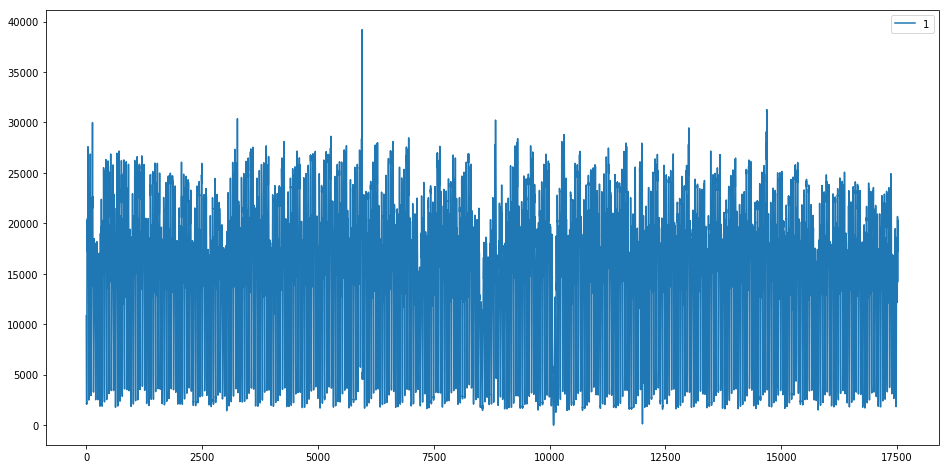

In [13]:
df.iloc[:,1:2].plot(figsize=(16,8))

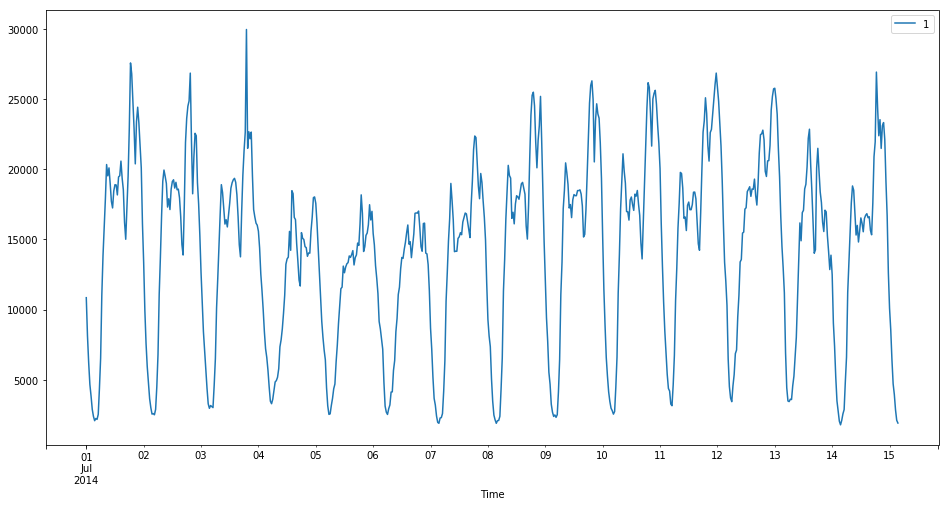

In [212]:
df.iloc[0:680,1:2].plot(figsize=(16,8))

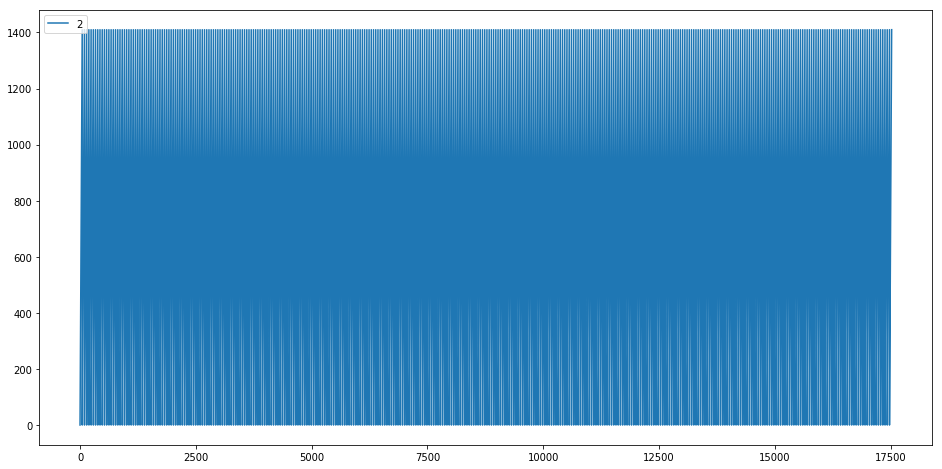

In [14]:
df.iloc[:,2:3].plot(figsize=(16,8))

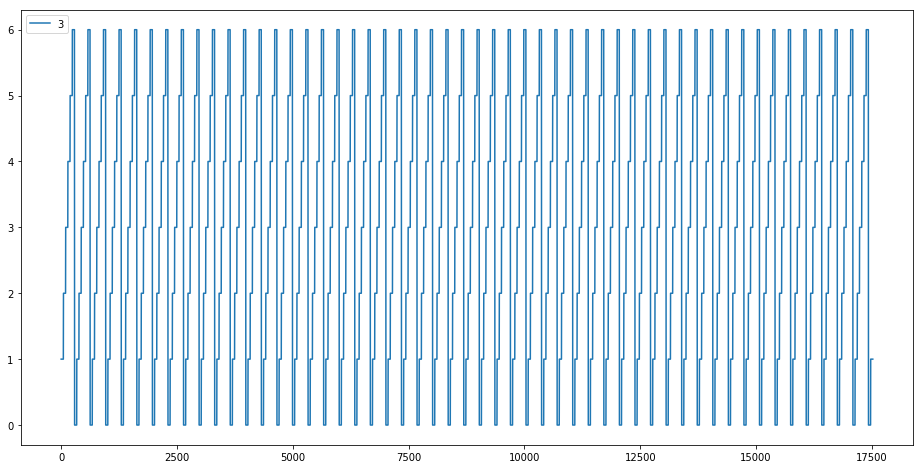

In [15]:
df.iloc[:,3:4].plot(figsize=(16,8))

In [16]:
df.iloc[:,0:1].head()

,0
0,2014-07-01 00:00:00
1,2014-07-01 00:30:00
2,2014-07-01 01:00:00
3,2014-07-01 01:30:00
4,2014-07-01 02:00:00


In [20]:
#df["timestamp"] = pd.to_datetime(df.iloc[:,0:1], format = '%Y-%m-%d %H:%M:%S')
#df['weekday'] = df['timestamp'].dt.dayofweek
#df['weekend'] = np.where(df['weekday']<5, 0, 1)
#df['hour_day'] = df['timestamp'].dt.hour

#df.head(68)

In [21]:
#enc = OneHotEncoder()
#enc.fit(df[['weekend','weekday','hour_day']])  
#time_encoder = enc.transform(df[['weekend', 'weekday', 'hour_day']]).toarray()

data_t = df.iloc[:,1:2].values
data_t.shape# , time_encoder.shape

(17520, 1)

# stationarity test

In [46]:
from statsmodels.tsa.stattools import adfuller


In [54]:
# copied from https://github.com/miguelTorresPorta/TimeSeries/blob/master/timeSeries.ipynb
def stationarity_test(data):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(data, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

    p_value = dftest[1]

    print("********************************")
    if p_value <= 0.05:
        print("Data is stationary\n")
    else:
        print("Data is non-stationary\n")
        
        
stationarity_test(df[1]) #.iloc[:,1:2])
#stationarity_test(df.iloc[:,2:3].values)

#stationarity_test(df[2])
#stationarity_test(df[3])

Results of Dickey-Fuller Test:
Test Statistic                -7.710323e+00
p-value                        1.268944e-11
#Lags Used                     4.400000e+01
Number of Observations Used    1.747500e+04
Critical Value (1%)           -3.430724e+00
Critical Value (5%)           -2.861705e+00
Critical Value (10%)          -2.566858e+00
dtype: float64
********************************
Data is stationary



In [50]:
df[1].head()

0    10844
1     8127
2     6210
3     4656
4     3820
Name: 1, dtype: int64

# Auto correlation and sequence-length

In [56]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm

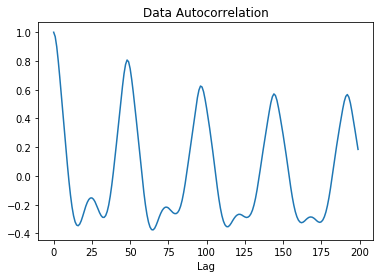

In [59]:
data_autocorr = [df[1].autocorr(i) for i in range(200)]
plt.plot(data_autocorr)
plt.title("Data Autocorrelation")
plt.xlabel("Lag")
plt.show()

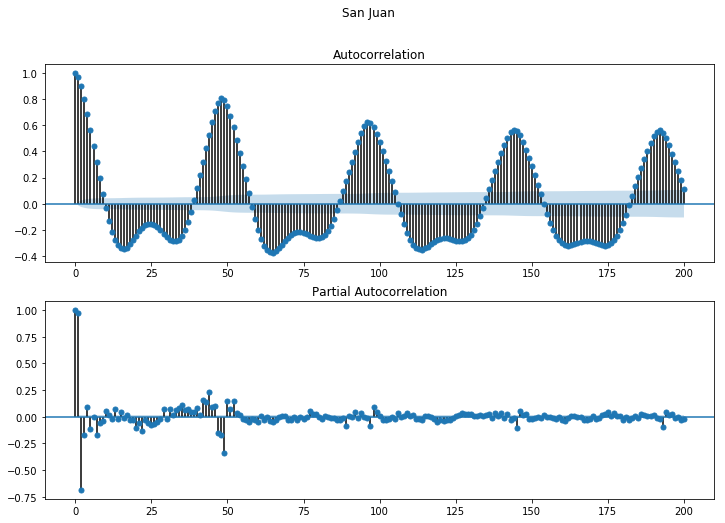

In [90]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df[1], lags=200, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df[1], lags=200, ax=ax2)
fig.suptitle("San Juan");

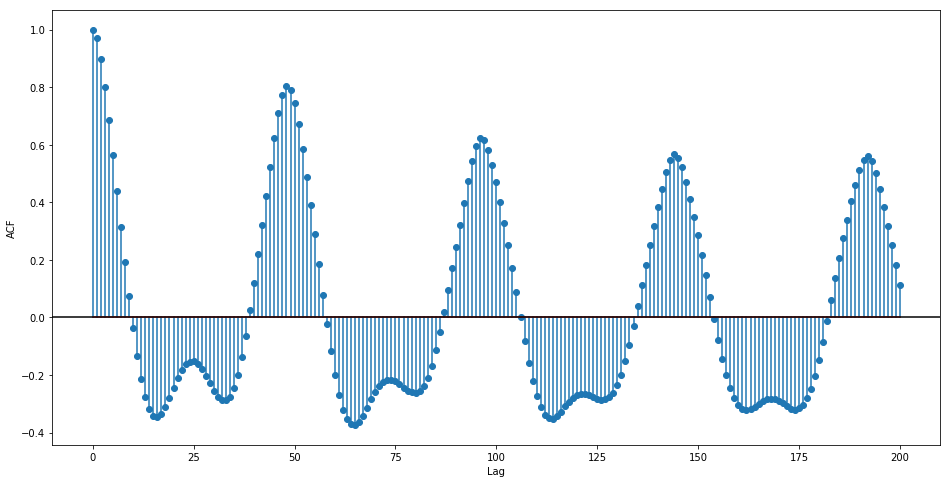

In [211]:
from statsmodels.tsa.stattools import acf
import matplotlib.pylab as plt

data = df[1]
lac_acf = acf(data, nlags=200)

plt.figure(figsize=(35,8))
plt.subplot(121)
plt.stem(lac_acf)
plt.axhline(y=0, linestyle='-', color='black')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

# Decomposition

In [193]:
df[0].head()

0    2014-07-01 00:00:00
1    2014-07-01 00:30:00
2    2014-07-01 01:00:00
3    2014-07-01 01:30:00
4    2014-07-01 02:00:00
Name: 0, dtype: object

In [203]:
df['Time'] =  pd.to_datetime(df[0], format = '%Y-%m-%d %H:%M:%S')
dff = df[['Time',1]]
dff.head()

,Time,1
Time,,
2014-07-01 00:00:00,2014-07-01 00:00:00,10844
2014-07-01 00:30:00,2014-07-01 00:30:00,8127
2014-07-01 01:00:00,2014-07-01 01:00:00,6210
2014-07-01 01:30:00,2014-07-01 01:30:00,4656
2014-07-01 02:00:00,2014-07-01 02:00:00,3820


In [204]:
dff = dff.set_index('Time')

In [205]:
import statsmodels.api as sm

# Beware seasonal_decompose() expects a DateTimeIndex on your DataFrame.
decomposition = sm.tsa.seasonal_decompose(dff[1], model='additive')
fig = decomposition.plot()
plt.figure(figsize=(15,5))
plt.show()


ValueError: freq T not understood. Please report if you think this is in error.

In [64]:
seq_length

48

In [91]:
seq_length = 48

In [92]:
#def data_preparing(data, time_encoder, forecasting_length=1):
def data_preparing(data, forecasting_length=1):
    kpi = data
    kpi = np.array(kpi).reshape((len(data), 1))

    # train the standardization
    scaler = MinMaxScaler()
    scaler = scaler.fit(kpi)
    # standardization the dataset and print the first 5 rows
    normalized = scaler.transform(kpi)
    kept_value = normalized.flatten().tolist()

    kept_values = []
    for i in range(len(kept_value)):
        #kept_values.append([kept_value[i]]+time_encoder[i].tolist())
        kept_values.append(kept_value[i])

    X,Y = [],[]
    for i in range(len(kept_values) - seq_length - forecasting_length):
        t=i+seq_length
        X.append(kept_values[i:t])
        Y.append(kept_value[t:t + forecasting_length])

    #X = np.asarray(X)
    X = np.expand_dims(X, axis=2)
    Y = np.expand_dims(Y, axis=2)
    
    Xmax = float(scaler.data_max_)
    Xmin = float(scaler.data_min_)

    X_train = X[:(int(len(X)) - 120)]
    Y_train = Y[:(int(len(Y)) - 120)]
    X_val = X[(int(len(X)) - 120):(int(len(X)) - 60)]
    Y_val = Y[(int(len(Y)) - 120):(int(len(Y)) - 60)]
    X_test = X[(int(len(X)) - 60):]
    Y_test = Y[(int(len(Y)) - 60):]  

    X_train = X_train.transpose((1, 0, 2))
    Y_train = Y_train.transpose((1, 0, 2))
    X_test = X_test.transpose((1, 0, 2))
    Y_test = Y_test.transpose((1, 0, 2))
    X_val = X_val.transpose((1, 0, 2))
    Y_val = Y_val.transpose((1, 0, 2)) 
    Xfull = X.transpose((1, 0, 2))
    Yfull = Y.transpose((1, 0, 2))
 
    return Xfull, Yfull, X_train, Y_train, X_test, Y_test, X_val, Y_val, Xmax, Xmin

In [93]:
forecast_len = 1

In [94]:
#Xfull, Yfull, Xtr, Ytr, Xts, Yts, Xv, Yv, Xmax, Xmin = data_preparing(data_t, time_encoder, forecasting_length=forecast_len)

Xfull, Yfull, Xtr, Ytr, Xts, Yts, Xv, Yv, Xmax, Xmin = data_preparing(data_t, forecasting_length=forecast_len)
#
# Internal neural network parameters
seq_length = Xfull.shape[0]
out_length = Yfull.shape[0]        
# Output dimension (e.g.: multiple signals at once, tied in time)
output_dim = Yfull.shape[-1]
input_dim = Xfull.shape[-1]        


/Users/manjunath.adinarayan/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [95]:
Xtr_f = np.ones((1, Xtr.shape[1], input_dim-1))
Xts_f = np.ones((1, Xts.shape[1], input_dim-1))
Xv_f = np.ones((1, Xv.shape[1], input_dim-1))
Xfull_f = np.ones((1, Xfull.shape[1], input_dim-1)) 

In [96]:
seq_length, out_length, output_dim, input_dim

(48, 1, 1, 1)

In [97]:
Xfull.shape, Yfull.shape,  Xmax, Xmin

((48, 17471, 1), (1, 17471, 1), 39197.0, 8.0)

In [98]:
np.max(Xfull), np.min(Xfull)

(1.0000000000000002, 0.0)

In [99]:
Xtr.shape, Ytr.shape, Xts.shape, Yts.shape, Xv.shape, Yv.shape

((48, 17351, 1),
 (1, 17351, 1),
 (48, 60, 1),
 (1, 60, 1),
 (48, 60, 1),
 (1, 60, 1))

In [100]:
Xtr_f.shape, Xts_f.shape, Xv_f.shape, Xfull_f.shape

((1, 17351, 0), (1, 60, 0), (1, 60, 0), (1, 17471, 0))

In [101]:
try:
    tf.nn.seq2seq = tf.contrib.legacy_seq2seq
    tf.nn.rnn_cell = tf.contrib.rnn
    tf.nn.rnn_cell.GRUCell = tf.contrib.rnn.GRUCell
    print("TensorFlow's version : 1.0 (or more)")
except:
    print("TensorFlow's version : 0.12")

TensorFlow's version : 1.0 (or more)


In [102]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

/Users/manjunath.adinarayan/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1645: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [103]:
with tf.variable_scope("Encoder") as scope:
    # Encoder: inputs
    enc_inp = [
        tf.placeholder(tf.float32, shape=(None, input_dim), name="inp_{}".format(t))
        for t in range(seq_length)
    ]
    # Th encoder cell, multi-layered with dropout
    if high_seqlen_flag == 1:
        cells_enc = []
        for i in range(layers_stacked_count_enc):
            cell_enc = LSTMCell(hidden_dim_list_enc[i])
            cell_enc = tf.contrib.rnn.DropoutWrapper(cell_enc, output_keep_prob=1.0-dropout_list[i])    
            cells_enc.append(cell_enc)
        cell_enc = tf.contrib.rnn.MultiRNNCell(cells_enc)
        #cell_enc = tf.contrib.rnn.MultiRNNCell([LSTMCell(hidden_dim_list_enc[i]) for i in range(layers_stacked_count_enc)])
    else:
        cells_enc = []
        for i in range(layers_stacked_count_enc):
            cell_enc = GRUCell(hidden_dim_list_enc[i])
            cell_enc = tf.contrib.rnn.DropoutWrapper(cell_enc, output_keep_prob=1.0-dropout_list[i])    
            cells_enc.append(cell_enc)
        cell_enc = tf.contrib.rnn.MultiRNNCell(cells_enc)
        #cell_enc = tf.contrib.rnn.MultiRNNCell([GRUCell(hidden_dim_list_enc[i]) for i in range(layers_stacked_count_enc)])

    #cell_enc = tf.contrib.rnn.DropoutWrapper(cell_enc, output_keep_prob=self.keep_prob)    

    encoder_outputs, encoder_final_state = tf.contrib.rnn.static_rnn(cell_enc,
                                              inputs=enc_inp, dtype=tf.float32)

In [104]:
with tf.variable_scope("Decoder") as scope:
    # Decoder: inputs    
    dummy_zero_input = [tf.zeros_like(enc_inp[0], dtype=np.float32, name="GO_dummy_zero_input")]
    
    # Decoder: expected outputs
    expected_sparse_output = [
        tf.placeholder(tf.float32, shape=(None, output_dim), name="expected_sparse_output_".format(t))
        for t in range(out_length)
    ]

    w_out = tf.Variable(tf.random_normal([out_hidden_dim, output_dim]))
    b_out = tf.Variable(tf.random_normal([output_dim]))
    
    # The decoder, also multi-layered
    if high_seqlen_flag == 1:
        cells_dec = []
        for i in range(layers_stacked_count_dec):
            cell_dec = LSTMCell(hidden_dim_list_dec[i])
            cell_dec = tf.contrib.rnn.DropoutWrapper(cell_dec, output_keep_prob=1.0-dropout_list[i])    
            cells_dec.append(cell_dec)
        cell_dec = tf.contrib.rnn.MultiRNNCell(cells_dec)
        #cell_dec = tf.contrib.rnn.MultiRNNCell([LSTMCell(hidden_dim_list_dec[i]) for i in range(layers_stacked_count_dec)])
    else:
        cells_dec = []
        for i in range(layers_stacked_count_dec):
            cell_dec = GRUCell(hidden_dim_list_dec[i])
            cell_dec = tf.contrib.rnn.DropoutWrapper(cell_dec, output_keep_prob=1.0-dropout_list[i])    
            cells_dec.append(cell_dec)
        cell_dec = tf.contrib.rnn.MultiRNNCell(cells_dec)
        #cell_dec = tf.contrib.rnn.MultiRNNCell([GRUCell(hidden_dim_list_dec[i]) for i in range(layers_stacked_count_dec)])
       
    def loop_fn(time, cell_output, cell_state, loop_state):
        emit_output = cell_output  # == None for time == 0
        if cell_output is None:
            next_cell_state = encoder_final_state            
            next_input = dummy_zero_input[0] 
        else:  
            next_cell_state = cell_state
            next_input = tf.add(tf.matmul(cell_output, w_out), b_out)          

        elements_finished = (time >= out_length)
        next_loop_state = None
        return (elements_finished, next_input, next_cell_state,
                emit_output, next_loop_state)        
    
    decoder_outputs_ta, decoder_final_state, _ = tf.nn.raw_rnn(cell_dec, loop_fn)
    decoder_outputs = decoder_outputs_ta.stack()
    
    decoder_max_steps, decoder_batch_size, decoder_dim = tf.unstack(tf.shape(decoder_outputs))
    decoder_outputs_flat = tf.reshape(decoder_outputs, (-1, decoder_dim))
    
    decoder_predictions = tf.add(tf.matmul(decoder_outputs_flat, w_out), b_out)
    reshaped_outputs = tf.reshape(decoder_predictions, (out_length, -1, output_dim))

In [105]:
# Training loss and optimizer
with tf.variable_scope('Loss'):
    
    epsilon = 0.01  # Smoothing factor, helps SMAPE to be well-behaved near zero    
    true_o = expected_sparse_output
    pred_o = reshaped_outputs
    summ = tf.maximum(tf.abs(true_o) , epsilon) 
    smape_ = tf.abs(pred_o - true_o) / summ #* 2.0    
    sloss =tf.losses.compute_weighted_loss(smape_, loss_collection=None)
    loss = sloss 

In [106]:
tf.train.AdamOptimizer


tensorflow.python.training.adam.AdamOptimizer

In [107]:
tf.train.RMSPropOptimizer

tensorflow.python.training.rmsprop.RMSPropOptimizer

In [108]:
with tf.variable_scope('Optimizer'):  # AdamOptimizer
    optimizer = tf.train.RMSPropOptimizer(
        learning_rate, decay=lr_decay, momentum=momentum)
    
    #optimizer = tf.train.AdamOptimizer(learning_rate)
    
    train_op = optimizer.minimize(loss)

In [109]:
def train_batch(Xtr, Ytr):
    """
    Training step that optimizes the weights
    provided some batch_size X and Y examples from the dataset.
    """
    #Xtr_f = np.ones((1, Xtr.shape[1], input_dim-1))
    feed_dict = {enc_inp[t]: Xtr[t] for t in range(len(enc_inp))}
    #feed_dict.update({feats[t]: Xtr_f[t] for t in range(len(feats))} )
    feed_dict.update({expected_sparse_output[t]: Ytr[
                     t] for t in range(len(expected_sparse_output))})
    _, loss_t = sess.run([train_op, loss], feed_dict)
    return loss_t

In [110]:
def test_batch(Xts, Yts):
    """
    Test step, does NOT optimizes. Weights are frozen by not
    doing sess.run on the train_op.
    """    
    #Xts_f = np.ones((1, Xts.shape[1], input_dim-1))
    feed_dict = {enc_inp[t]: Xts[t] for t in range(len(enc_inp))}
    #feed_dict.update({feats[t]: Xts_f[t] for t in range(len(feats))} )
    feed_dict.update({expected_sparse_output[t]: Yts[
                     t] for t in range(len(expected_sparse_output))})
    loss_t = sess.run([loss], feed_dict)
    return loss_t[0]


In [111]:
nb_iters

460

In [112]:
nb_iters=460

In [113]:
# Training
train_losses = []
test_losses = []

sess.run(tf.global_variables_initializer())
cnt=0
early_stop = 128
Reps, Features = [], []
tmp_loss = []
for t in range(nb_iters + 1):
    train_loss = train_batch(Xtr, Ytr)
    train_losses.append(train_loss)    
    
    test_loss = test_batch(Xts, Yts)
    test_losses.append(test_loss)
    print("Step {}/{}, train loss: {}, \tTEST loss: {}".format(t,
                                                               nb_iters, train_loss, test_loss))
    if t > 6:
        if test_loss > np.min(test_losses[:(len(test_losses)-1)]):
            tracking_start = 1
            tmp_loss.append(test_loss)
#    if tracking_start == 1 and patience == 0:
#        tmp_loss=[]            
    if len(tmp_loss) == early_stop:    
        print("Early-stopping and breaking")
        break

print("Final. train loss: {}, \tTEST loss: {}".format(train_loss, test_loss))


Step 0/460, train loss: 4.343374252319336, 	TEST loss: 2.540178060531616
Step 1/460, train loss: 2.328425407409668, 	TEST loss: 1.5308549404144287
Step 2/460, train loss: 1.6980608701705933, 	TEST loss: 1.9752269983291626
Step 3/460, train loss: 1.8913235664367676, 	TEST loss: 1.3677749633789062
Step 4/460, train loss: 1.5238327980041504, 	TEST loss: 1.4822839498519897
Step 5/460, train loss: 1.4131377935409546, 	TEST loss: 1.5403456687927246
Step 6/460, train loss: 1.4170781373977661, 	TEST loss: 1.2425631284713745
Step 7/460, train loss: 1.3265137672424316, 	TEST loss: 1.2359333038330078
Step 8/460, train loss: 1.3185522556304932, 	TEST loss: 1.3398478031158447
Step 9/460, train loss: 1.2859911918640137, 	TEST loss: 0.9996664524078369
Step 10/460, train loss: 1.2478471994400024, 	TEST loss: 1.3947832584381104
Step 11/460, train loss: 1.2254517078399658, 	TEST loss: 1.1579071283340454
Step 12/460, train loss: 1.2093394994735718, 	TEST loss: 1.115946888923645
Step 13/460, train loss: 1

Step 108/460, train loss: 0.3659919798374176, 	TEST loss: 0.3019038736820221
Step 109/460, train loss: 0.3472946286201477, 	TEST loss: 0.3142479956150055
Step 110/460, train loss: 0.3493925929069519, 	TEST loss: 0.3151775598526001
Step 111/460, train loss: 0.35547611117362976, 	TEST loss: 0.42269518971443176
Step 112/460, train loss: 0.39516839385032654, 	TEST loss: 0.3499293625354767
Step 113/460, train loss: 0.38594719767570496, 	TEST loss: 0.3958579897880554
Step 114/460, train loss: 0.37618958950042725, 	TEST loss: 0.3957822918891907
Step 115/460, train loss: 0.35323742032051086, 	TEST loss: 0.36988478899002075
Step 116/460, train loss: 0.3514343500137329, 	TEST loss: 0.3318081498146057
Step 117/460, train loss: 0.342976838350296, 	TEST loss: 0.334042489528656
Step 118/460, train loss: 0.349158376455307, 	TEST loss: 0.2901289165019989
Step 119/460, train loss: 0.3463806211948395, 	TEST loss: 0.38203710317611694
Step 120/460, train loss: 0.35737332701683044, 	TEST loss: 0.3055418729

In [118]:
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.nanmean(diff)

def mape(y_true, y_pred):
    denominator = (np.abs(y_true) )
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.nanmean(diff)

In [119]:
print("\n TEST DATA ") #, Xts.shape, Yts.shape)
feed_dict = {enc_inp[t]: Xts[t] for t in range(seq_length)}
#feed_dict.update({dropout : 0.5})
outputs_ts = np.array(sess.run([reshaped_outputs], feed_dict)[0])
 
print("MAPE : = ", mape(Yts, outputs_ts))    
test_smape = smape(Yts, outputs_ts)   
print("SMAPE : = ", test_smape)   


 TEST DATA 
MAPE : =  0.21975304700228948
SMAPE : =  0.2547562506022503


In [125]:
Yts.shape, outputs_ts.shape#
Yts[:,0:6,:], outputs_ts[:,0:6,:]

(array([[[0.39666743],
         [0.44933527],
         [0.49092858],
         [0.49692516],
         [0.4672995 ],
         [0.44300697]]]), array([[[0.26012835],
         [0.40359223],
         [0.42179427],
         [0.2966519 ],
         [0.71600294],
         [0.5098135 ]]], dtype=float32))

In [120]:
print("\n VALIDATION DATA ")#, Xv.shape, Yv.shape)
feed_dict = {enc_inp[t]: Xv[t] for t in range(seq_length)}
#feed_dict.update({dropout : 0.5})
outputs_v = np.array(sess.run([reshaped_outputs], feed_dict)[0])
  
print("MAPE : = ", mape(Yv, outputs_v))    
print("SMAPE : = ", smape(Yv, outputs_v),"\n")  


 VALIDATION DATA 
MAPE : =  0.21715345976148073
SMAPE : =  0.23863628530755504 



In [121]:
print("\n TRAIn DATA ") #, Xtr.shape, Ytr.shape)
feed_dict = {enc_inp[t]: Xtr[t] for t in range(seq_length)}
#feed_dict.update({dropout : 0.5})
outputs_tr = np.array(sess.run([reshaped_outputs], feed_dict)[0])
 
print("MAPE : = ", mape(Ytr, outputs_tr))    
print("SMAPE : = ", smape(Ytr, outputs_tr))   


 TRAIn DATA 
MAPE : =  0.4211993930127967
SMAPE : =  0.28544540681132397


/Users/manjunath.adinarayan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


In [130]:
q = np.array(sess.run([reshaped_outputs], feed_dict) )
q.shape, q[0].shape, q[0][0].shape

((1, 1, 17351, 1), (1, 17351, 1), (17351, 1))

In [132]:
def rescalig(Y,Xmax,Xmin):
    X = Y * (Xmax - Xmin) + Xmin
    return X

## MONTE CARLO METHODS APPLICATION  FOR FULL/ENTIRE DATA

In [133]:

#Xv_f = np.ones((1, Xv.shape[1], input_dim-1))
#Xfull_f = np.ones((1, Xfull.shape[1], input_dim-1))
feed_dict = {enc_inp[t]: Xfull[t] for t in range(seq_length)}
#feed_dict.update({feats[t]: Xfull_f[t] for t in range(len(feats))} )
outputs_full = np.array(sess.run([reshaped_outputs], feed_dict)[0])
Yfull_original = rescalig(Yfull,Xmax,Xmin)
outputs_original = rescalig(outputs_full,Xmax,Xmin)

Yfull_original.shape, outputs_original.shape, Yfull.shape, outputs_full.shape

((1, 17471, 1), (1, 17471, 1), (1, 17471, 1), (1, 17471, 1))

In [134]:
feed_dict = {enc_inp[t]: Xfull[t] for t in range(seq_length)}

uncertainty=[]
for rept in range(0, 100):
    outputs = np.array(sess.run([reshaped_outputs], feed_dict)[0])
    diff = ((Yfull - outputs) ** 2).mean()
    uncertainty.append(diff)
    
eta1 = np.sqrt(np.mean(uncertainty))
print("\n eta1 = ", eta1)

#validation Errors
feed_dict = {enc_inp[t]: Xv[t] for t in range(seq_length)}
#feed_dict.update({feats[t]: Xv_f[t] for t in range(len(feats))} )
outputs = np.array(sess.run([reshaped_outputs], feed_dict)[0])

eta2 = np.sqrt(((Yv - outputs) ** 2).mean())
print("\n eta2 = ", eta2)    

eta = np.sqrt( ((eta1)**2) + ((eta2)**2) )
print("\n Eta = ", eta)


 eta1 =  0.11554383352787748

 eta2 =  0.08808072616200179

 Eta =  0.14528796160571394


In [136]:
uncertainty[0:8], diff

([0.013241764221380865,
  0.013184811943246064,
  0.013074827149545979,
  0.013291136949891307,
  0.01303795266455425,
  0.013278948503082234,
  0.013684905899777026,
  0.0133611887209309],
 0.013409357116683562)

In [137]:
Y_true=np.reshape(Yfull_original,(Yfull_original.shape[1],1))
Y_pred=np.reshape(outputs_original,(outputs_original.shape[1],1))

Y_true.shape, Y_pred.shape

((17471, 1), (17471, 1))

In [138]:
Y_true_=np.reshape(Yfull,(Yfull.shape[1],1))
Y_pred_=np.reshape(outputs_full,(outputs_full.shape[1],1))

Y_true_.shape, Y_pred_.shape

((17471, 1), (17471, 1))

In [141]:
np.max(Y_true_), np.min(Y_true_), np.max(Y_pred_), np.min(Y_pred_)

(1.0000000000000002, 0.0, 1.3165545, -0.123874635)

In [142]:
np.max(Y_true), np.min(Y_true), np.max(Y_pred), np.min(Y_pred)

(39197.00000000001, 8.0, 51602.457, -4846.523)

In [ ]:
anomaly_type_list = []
isanomaly_list = []
anomaly_score_list = []
output_list = []
upper_bound_list = []
lower_bound_list = []
actual_list = []

In [143]:
outputs_full.shape, Yfull.shape

((1, 17471, 1), (1, 17471, 1))

In [145]:
outputs.reshape([-1]).shape

(60,)

In [180]:
confidance_interval = 1.64
#confidance_interval = 0.95

In [181]:
anomaly_count=0
Is_anomaly_list = []
outputs_pred = outputs_full.reshape([-1])
Yfull_ = Yfull.reshape([-1])
for output_pred,actual in zip(outputs_pred,Yfull_):
    upper_bound = float( output_pred + (confidance_interval*eta) )
    lower_bound = float( output_pred - (confidance_interval*eta) )
    if(actual>output):
        anomaly_type = "upward"
    else:
        anomaly_type = "downward"
        
    if(actual<=upper_bound and actual>= lower_bound):
        Is_anomaly_list.append(0)
    else:
        Is_anomaly_list.append(1)
        anomaly_count = anomaly_count + 1
        
anomaly_count, len(Is_anomaly_list), np.count_nonzero(Is_anomaly_list)

(825, 17471, 825)

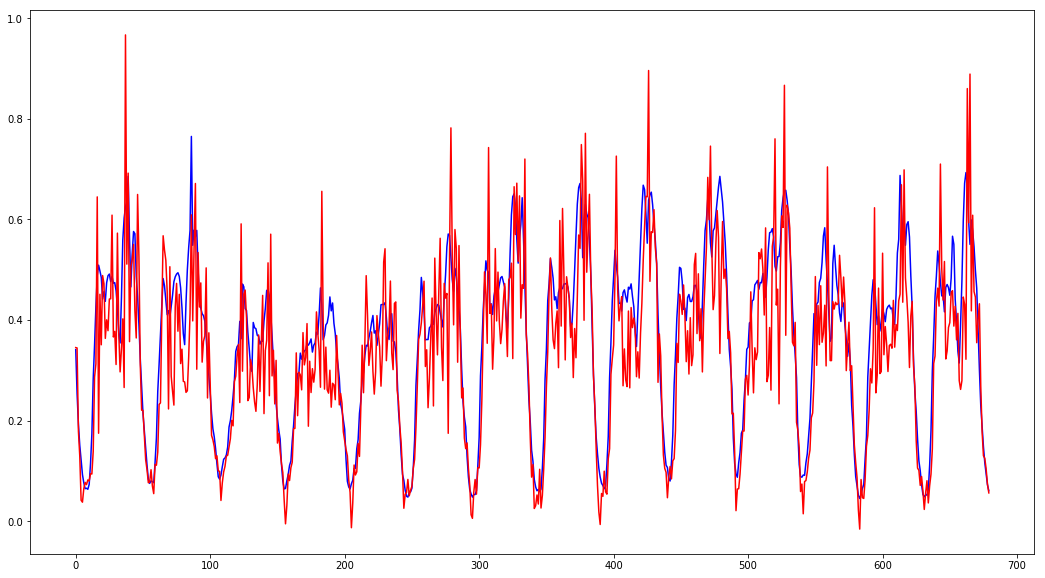

In [213]:
plt.plot(Yfull_[0:680], color='blue')
plt.plot(outputs_pred[0:680], color='red')
#plt.stem(Is_anomaly_list)
plt.show()

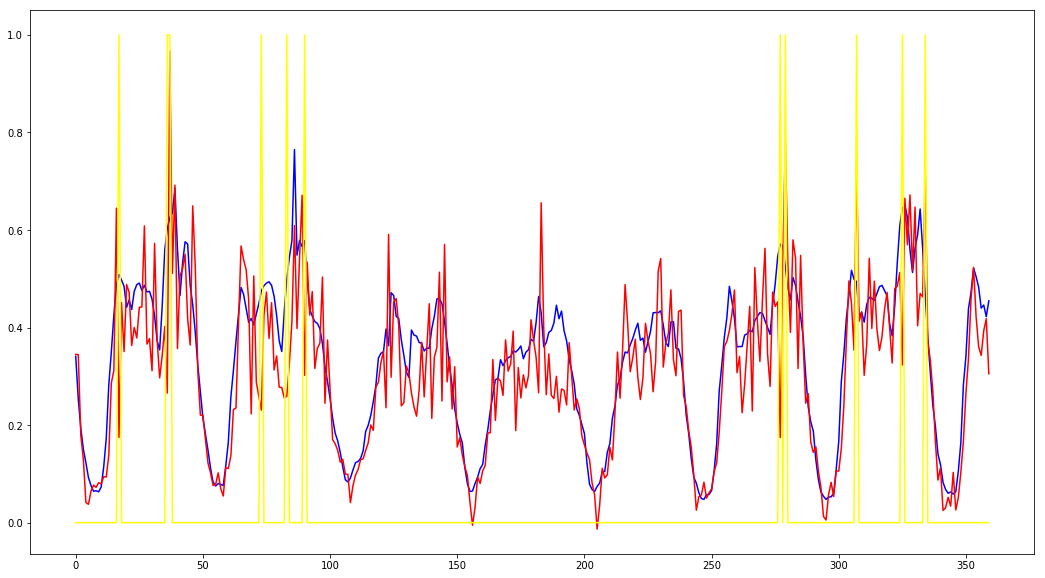

In [217]:
plt.plot(Yfull_[0:360], color='blue')
plt.plot(outputs_pred[0:360], color='red')
plt.plot(Is_anomaly_list[0:360], color='yellow')
plt.show()

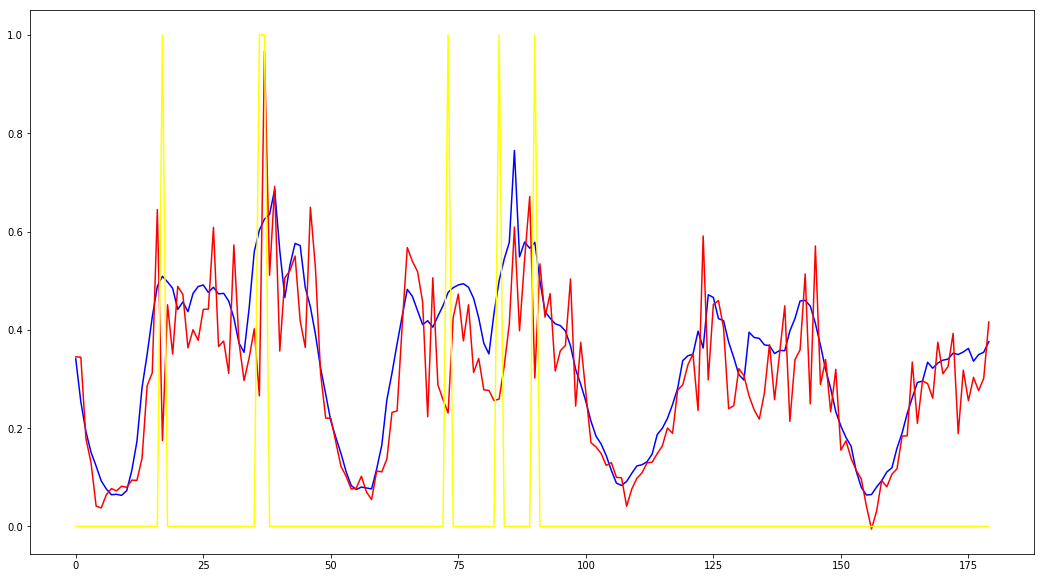

In [218]:
plt.plot(Yfull_[0:180], color='blue')
plt.plot(outputs_pred[0:180], color='red')
plt.plot(Is_anomaly_list[0:180], color='yellow')
plt.show()

In [183]:
#plt.stem(Is_anomaly_list)
#plt.show()

In [184]:
start = 0
end = 256

In [185]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [18, 10]

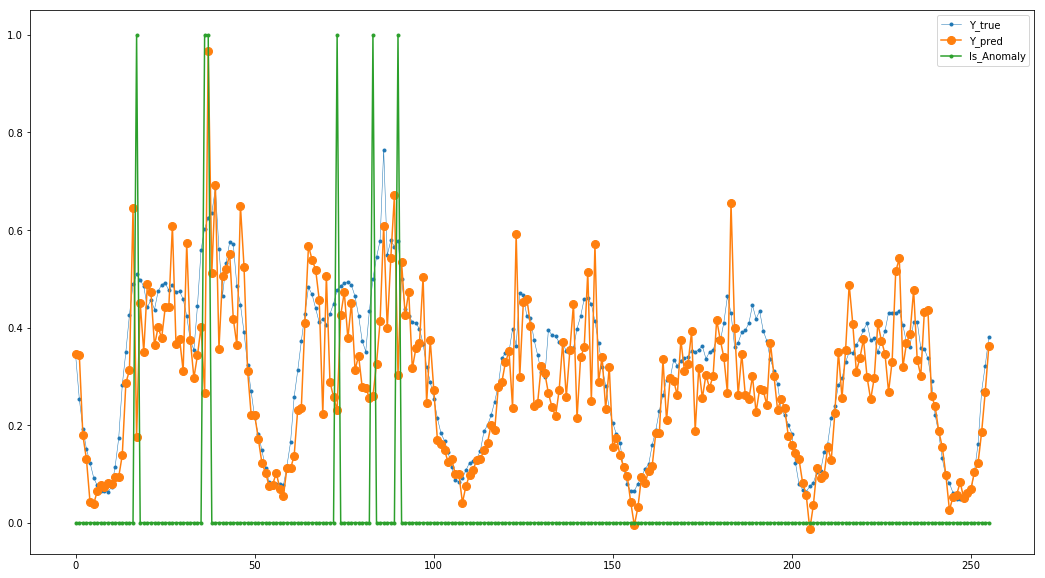

In [186]:
fig, ax = plt.subplots()
ax.plot(Yfull_[start:end],
marker='.', linestyle='-', linewidth=0.5, label='Y_true')

ax.plot(outputs_pred[start:end],
marker='o', markersize=8, linestyle='-', label='Y_pred')

ax.plot(Is_anomaly_list[start:end],
marker='.', linestyle='-', label='Is_Anomaly')

#ax.set_ylabel('Solar Production (GWh)')
ax.legend();

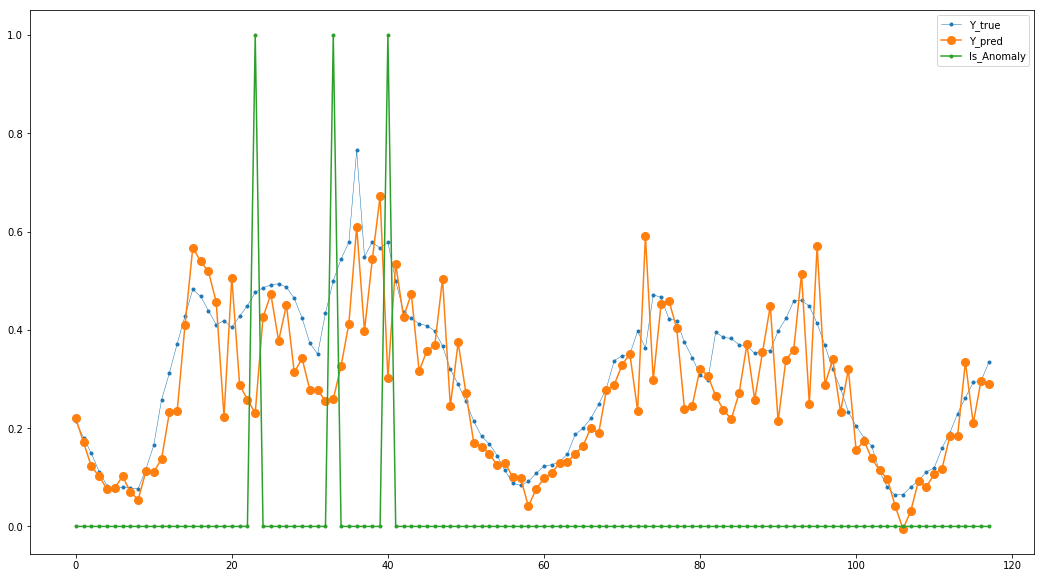

In [187]:
start = 50
end = 168

fig, ax = plt.subplots()
ax.plot(Yfull_[start:end],
marker='.', linestyle='-', linewidth=0.5, label='Y_true')

ax.plot(outputs_pred[start:end],
marker='o', markersize=8, linestyle='-', label='Y_pred')

ax.plot(Is_anomaly_list[start:end],
marker='.', linestyle='-', label='Is_Anomaly')

#ax.set_ylabel('Solar Production (GWh)')
ax.legend();


# SPECTRAL RESIDUAL by MICROSOFT

In [219]:
import numpy as np
from scipy import stats

#from sranodec.util import marge_series, series_filter

In [226]:
def extrapolate_next(values):
    """
    Extrapolates the next value by sum up the slope of the last value with previous values.
    :param values: a list or numpy array of time-series
    :return: the next value of time-series
    """

    last_value = values[-1]
    slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]
    slope[0] = 0
    next_values = last_value + np.cumsum(slope)

    return next_values

In [227]:
def marge_series(values, extend_num=5, forward=5):

    next_value = extrapolate_next(values)[forward]
    extension = [next_value] * extend_num

    if isinstance(values, list):
        marge_values = values + extension
    else:
        marge_values = np.append(values, extension)
    return marge_values

def series_filter(values, kernel_size=3):
    """
    Filter a time series. Practically, calculated mean value inside kernel size.
    As math formula, see https://docs.opencv.org/2.4/modules/imgproc/doc/filtering.html.
    :param values:
    :param kernel_size:
    :return: The list of filtered average
    """
    filter_values = np.cumsum(values, dtype=float)

    filter_values[kernel_size:] = filter_values[kernel_size:] - filter_values[:-kernel_size]
    filter_values[kernel_size:] = filter_values[kernel_size:] / kernel_size

    for i in range(1, kernel_size):
        filter_values[i] /= i + 1

    return filter_values

In [228]:
class Silency(object):
    def __init__(self, amp_window_size, series_window_size, score_window_size):
        self.amp_window_size = amp_window_size
        self.series_window_size = series_window_size
        self.score_window_size = score_window_size

    def transform_silency_map(self, values):
        """
        Transform a time-series into spectral residual, which is method in computer vision.
        For example, See https://github.com/uoip/SpectralResidualSaliency.
        :param values: a list or numpy array of float values.
        :return: silency map and spectral residual
        """

        freq = np.fft.fft(values)
        mag = np.sqrt(freq.real ** 2 + freq.imag ** 2)
        spectral_residual = np.exp(np.log(mag) - series_filter(np.log(mag), self.amp_window_size))

        freq.real = freq.real * spectral_residual / mag
        freq.imag = freq.imag * spectral_residual / mag

        silency_map = np.fft.ifft(freq)
        return silency_map

    def transform_spectral_residual(self, values):
        silency_map = self.transform_silency_map(values)
        spectral_residual = np.sqrt(silency_map.real ** 2 + silency_map.imag ** 2)
        return spectral_residual

    def generate_anomaly_score(self, values, type="avg"):
        """
        Generate anomaly score by spectral residual.
        :param values:
        :param type:
        :return:
        """

        extended_series = marge_series(values, self.series_window_size, self.series_window_size)
        mag = self.transform_spectral_residual(extended_series)[: len(values)]

        if type == "avg":
            ave_filter = series_filter(mag, self.score_window_size)
            score = (mag - ave_filter) / ave_filter
        elif type == "abs":
            ave_filter = series_filter(mag, self.score_window_size)
            score = np.abs(mag - ave_filter) / ave_filter
        elif type == "chisq":
            score = stats.chi2.cdf((mag - np.mean(mag)) ** 2 / np.var(mag), df=1)
        else:
            raise ValueError("No type!")
        return score

In [229]:
# less than period
amp_window_size=24
# (maybe) as same as period
series_window_size=24
# a number enough larger than period
score_window_size=100

In [230]:
spec = Silency(amp_window_size, series_window_size, score_window_size)

/Users/manjunath.adinarayan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':


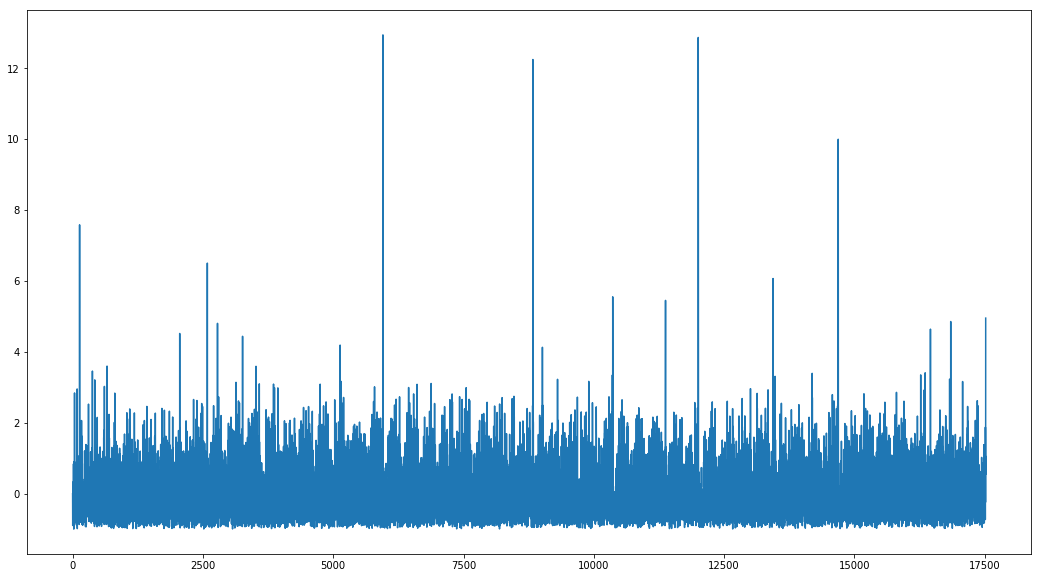

In [231]:
score = spec.generate_anomaly_score(df[1])
plt.plot(score)

In [242]:
test_signal = df.iloc[0:680,1:2].values
score = spec.generate_anomaly_score(test_signal)

/Users/manjunath.adinarayan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


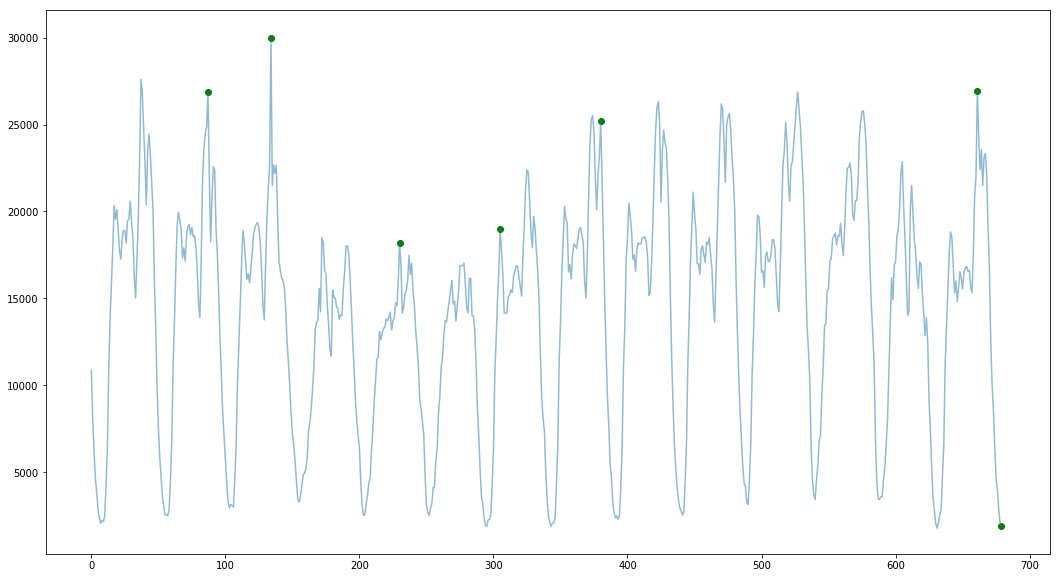

In [243]:
# Plot data with estimated anomalous points
plt.plot(test_signal, alpha=0.5, label="observation")
index_changes = np.where(score > np.percentile(score, 99))[0]
plt.scatter(index_changes, test_signal[index_changes], c='green', label="change point")

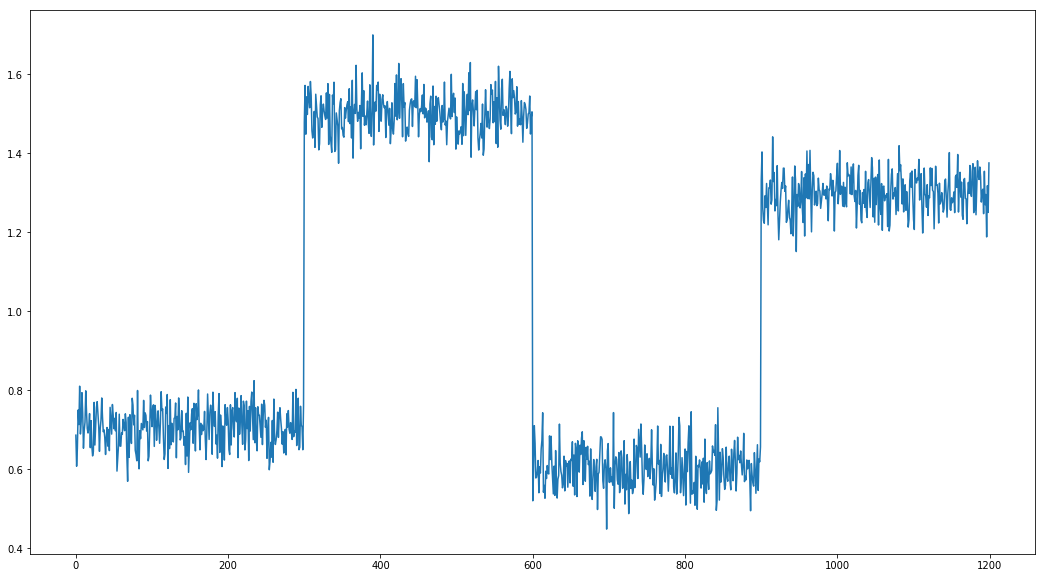

In [244]:
# Generate test data
test_signal = np.concatenate(
    [np.random.normal(0.7, 0.05, 300), 
     np.random.normal(1.5, 0.05, 300),
     np.random.normal(0.6, 0.05, 300),
     np.random.normal(1.3, 0.05, 300)])
plt.plot(test_signal)

In [245]:
type(test_signal)

numpy.ndarray

In [246]:
score = spec.generate_anomaly_score(test_signal)

/Users/manjunath.adinarayan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


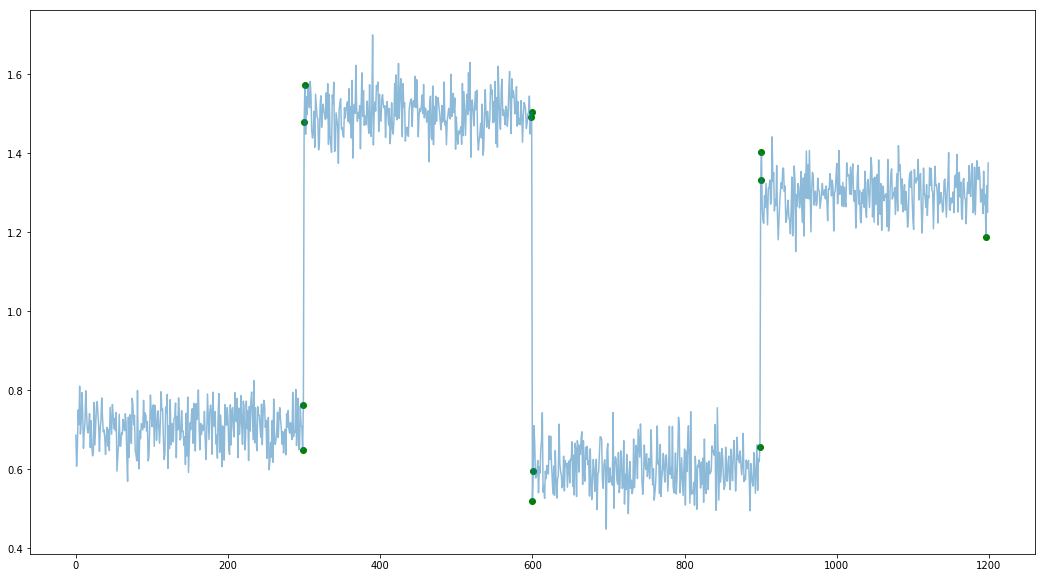

In [247]:
# Plot data with estimated anomalous points
plt.plot(test_signal, alpha=0.5, label="observation")
index_changes = np.where(score > np.percentile(score, 99))[0]
plt.scatter(index_changes, test_signal[index_changes], c='green', label="change point")